In [1]:
# file wrapper-concept.ipynb
# author Jim Smith Jan 2022
# note book to explore and illustrate the basic concept of a wrapper class

## Edited Andy McCarthy Feb 2022 to adapt to illustrate the use of safe_random_forest class
# params protected are boostrap==True and min_samples_leaf = 5

## Some basic examples to explore what the wrapper class could look like and be implemented

### Lets start by making some data with one disclosive case
- We'll do this by adding an example to the iris data and give it a new class to make things really obvious.
- The same risks exist for more complex data sets but _everyone knows iris_

In [32]:
import numpy as np
from sklearn import datasets

iris = datasets.load_iris()
X = iris.data
y = iris.target


# print the max and min values in each feature to help hand-craft the disclosive point
for feature in range(4):
    print(f"feature {feature} min {np.min(X[:,feature])}, min {np.max(X[:,feature])}")

# now add a single disclosve point with features [7,2,4.5,1] and label 3
X = np.vstack([X, (7, 2.0, 4.5, 1)])
y = np.append(y, 4)

feature 0 min 4.3, min 7.9
feature 1 min 2.0, min 4.4
feature 2 min 1.0, min 6.9
feature 3 min 0.1, min 2.5


### and import some basic libraries to show our point

In [33]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

## Here's the raw version
-  note I am setting random_state=1 to make it deterministic, just so you get the same results as me
 - the general point is not that someone always will, but that they could
 - in practice I ran 10 times not setting random state and got the same tree 4/5 times

Training set accuracy in this naive case is 1.0
Fairly randomly selecting two of thetrees in the forest to display


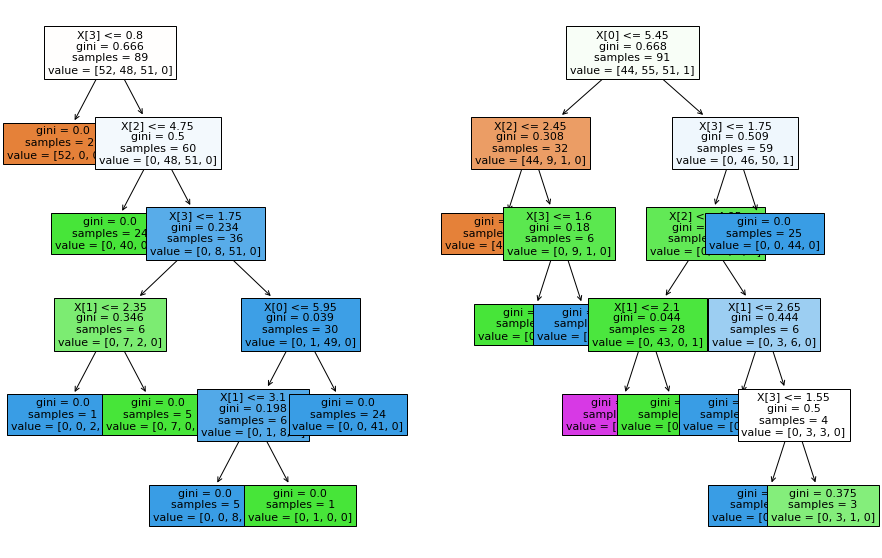

In [34]:
# example code with no safety

from sklearn.ensemble import RandomForestClassifier

rawRF = RandomForestClassifier(max_depth=5, random_state=1)
rawRF.fit(X, y)

print(f"Training set accuracy in this naive case is {rawRF.score(X,y)}")
print("Fairly randomly selecting two of the trees in the forest to display")

estimator = rawRF.estimators_[5]
estimator1 = rawRF.estimators_[50]

fig, ax = plt.subplots(1, 2, figsize=(15, 10))
_ = plot_tree(estimator, filled=True, ax=ax[0], fontsize=11)
_ = plot_tree(estimator1, filled=True, ax=ax[1], fontsize=11)

### As we can see we have several disclosive nodes, one of which is our added point (in purple)

- A single tree that has a leaf corresponding to our new point may not give tight bounds on every feature value
- But every additional tree restricts those bounds - especially if each uses different combinations of features
- so the risk of complete disclosure of that point increases.


### Diligent user realises problem, and changes their code to see if enforcing at least n samples in each leaf and/or  bootstrapping helps
- We'll use n=5 
- note that we need to combination of both of these

## Scenario. 1: Boostrap=True and min_samples_leaf = 1:  low MIA risk (per Simon) but singleton disclosure 

Training set accuracy in scenario 1 is 1.0


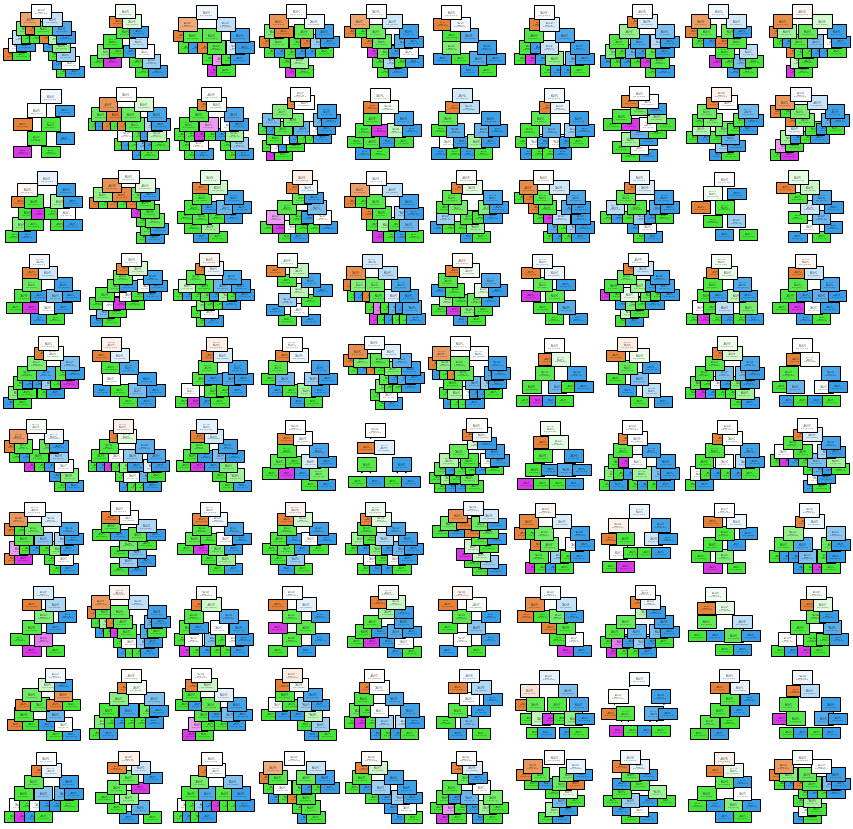

In [35]:
manualRF1 = RandomForestClassifier(bootstrap=True, min_samples_leaf=1, random_state=1)
manualRF1.fit(X, y)
print(f"Training set accuracy in scenario 1 is {manualRF1.score(X,y)}")
fig, ax = plt.subplots(10, 10, figsize=(15, 15))
for row in range(10):
    for column in range(10):
        whichTree = 10 * row + column
        treeRowCol = manualRF1.estimators_[whichTree]
        _ = plot_tree(treeRowCol, filled=True, ax=ax[row][column], fontsize=1)

## Scenario 2: Boostrap=True and min_samples_leaf = 5: no singleton disclosure  high MIA risk  (per Simon)

Training set accuracy in scenario 2 is 0.9668874172185431


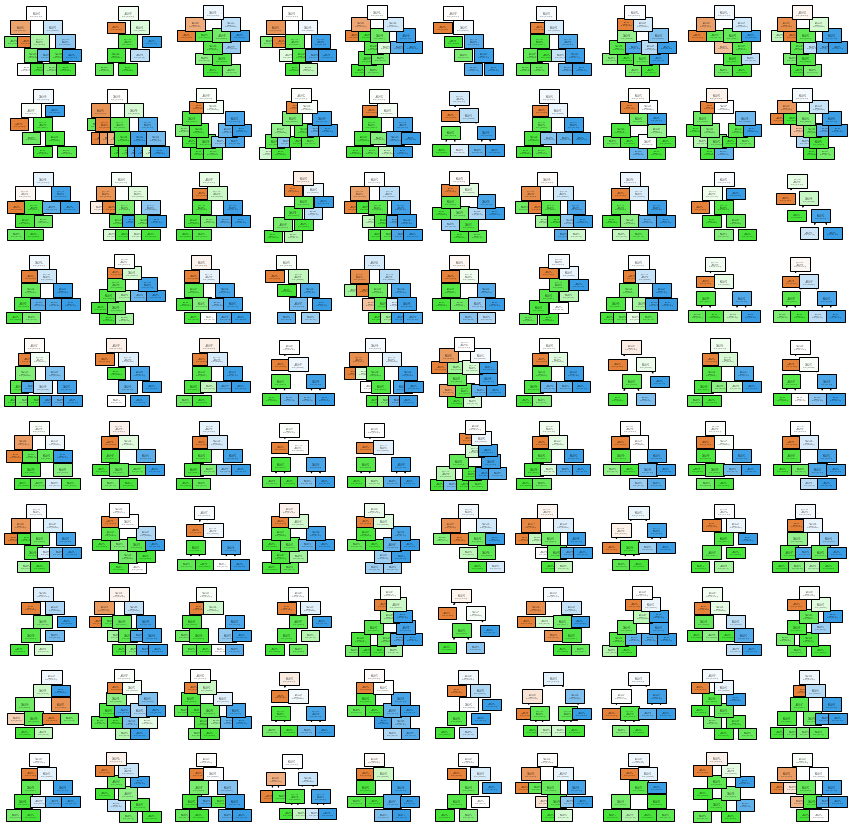

In [36]:
manualRF2 = RandomForestClassifier(bootstrap=True, min_samples_leaf=5, random_state=1)
manualRF2.fit(X, y)
print(f"Training set accuracy in scenario 2 is {manualRF2.score(X,y)}")
fig, ax = plt.subplots(10, 10, figsize=(15, 15))
for row in range(10):
    for column in range(10):
        whichTree = 10 * row + column
        treeRowCol = manualRF2.estimators_[whichTree]
        _ = plot_tree(treeRowCol, filled=True, ax=ax[row][column], fontsize=1)

## Scenario 3: Boostrap=True and min_samples_leaf = 5: no singleton disclosure, low MIA risk (per Simon)

Training set accuracy in scenario 3 is 0.9668874172185431


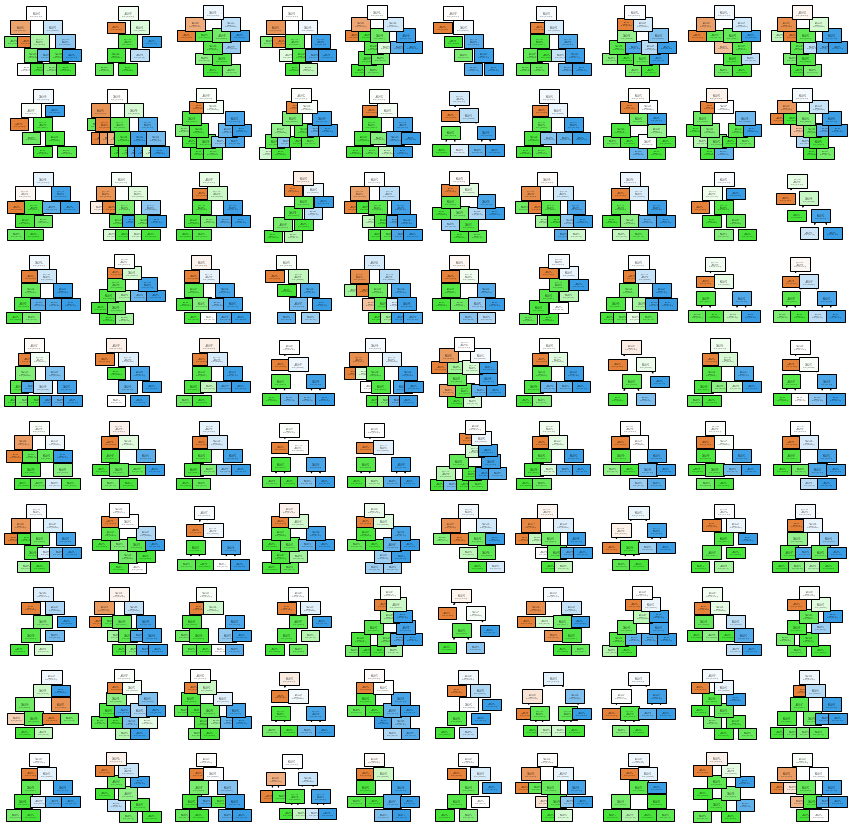

In [37]:
manualRF3 = RandomForestClassifier(bootstrap=True, min_samples_leaf=5, random_state=1)
manualRF3.fit(X, y)
print(f"Training set accuracy in scenario 3 is {manualRF3.score(X,y)}")
fig, ax = plt.subplots(10, 10, figsize=(15, 15))
for row in range(10):
    for column in range(10):
        whichTree = 10 * row + column
        treeRowCol = manualRF3.estimators_[whichTree]
        _ = plot_tree(treeRowCol, filled=True, ax=ax[row][column], fontsize=1)

### This shows we need both parameters to. be set for the output to be non-disclosive
- Simon has shown elsewhere Bootstrap =False leads to high MIA risk
- middle plot shows even bootstrap = True can lead to multiple trees with singleton leaves which pose individual disclosure risk
- You can easily see we don't get a node for the new class 3

## So lets define a new class SafeDecisionTree 
### after starting by removing the import of DecisionTreeClassfier

In [38]:
del RandomForestClassifier
try:
    shouldFail = RandomForestClassifier()
except:
    print(
        "call failed correctly, so we know RandomForestClassifier cannot be accessed directly"
    )

call failed correctly, so we know RandomForestClassifier cannot be accessed directly


In [57]:
import importlib, SafeModel

importlib.reload(SafeModel)


from SafeModel import SafeModel, SafeRandomForest

In [40]:
noNameModel = SafeModel()

try:
    print(noNameModel.__str__())
except:
    print("super class has no attributes to print")

super class has no attributes to print


In [30]:
safeRFModel = SafeRandomForest()  # (criterion="entropy")
print(safeRFModel.__str__())

RandomForestClassifier with parameters: {'base_estimator': DecisionTreeClassifier(), 'n_estimators': 100, 'estimator_params': ('criterion', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'min_weight_fraction_leaf', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'random_state', 'ccp_alpha'), 'bootstrap': 'True', 'oob_score': False, 'n_jobs': None, 'random_state': None, 'verbose': 0, 'warm_start': False, 'class_weight': None, 'max_samples': None, 'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'ccp_alpha': 0.0}


Training set accuracy in this safe case is 0.9735099337748344
Not the same as last time because I have not specified the random state and here are  the trees again


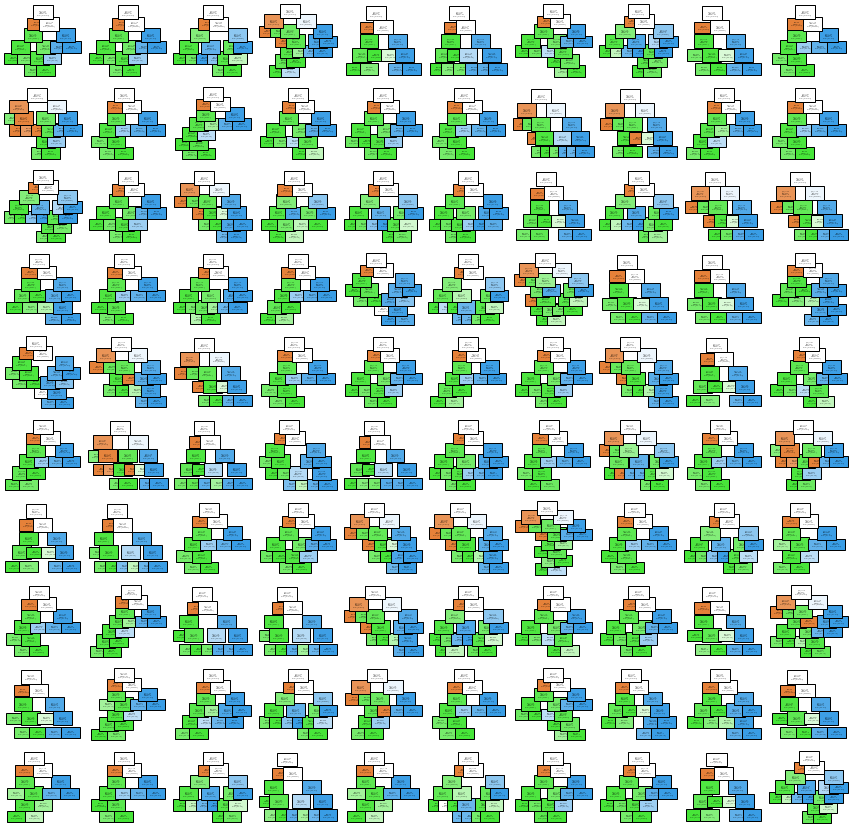

In [48]:
safeRFModel.fit(X, y)

print(f"Training set accuracy in this safe case is {safeRFModel.score(X,y)}")
print(
    "Not the same as last time because I have not specified the random state and here are  the trees again"
)

fig, ax = plt.subplots(10, 10, figsize=(15, 15))
for row in range(10):
    for column in range(10):
        whichTree = 10 * row + column
        treeRowCol = safeRFModel.estimators_[whichTree]
        _ = plot_tree(treeRowCol, filled=True, ax=ax[row][column], fontsize=1)

## Now demonstrate the save and reporting functionality

In [42]:
safeRFModel.save_model(name="testSaveRF.pkl")
safeRFModel.preliminary_check()
# safeDTmodel.request_release()

checking key bootstrap: current_val True, recommended True
checking key min_samples_leaf: current_val 5, recommended 5
Model has not been changed to increase risk of disclosure. These are the params:

	parameter min_samples_leaf unchanged at recommended value 5




## Now lets try to attack this approach
### starting with listing the params then trying to set the params manually after init

In [43]:
print(safeRFModel.__dict__)
# print(safeRFModel.model)
# print(safeRFModel.model.__dict__)

{'model_type': 'RandomForestClassifier', 'model': RandomForestClassifier(bootstrap='True', min_samples_leaf=5), 'model_save_file': 'testSaveRF.pkl', 'filename': 'None', 'researcher': 'j4-smith'}


Training set accuracy in this naive case is 1.0
you cna see there are now unsafe trees again


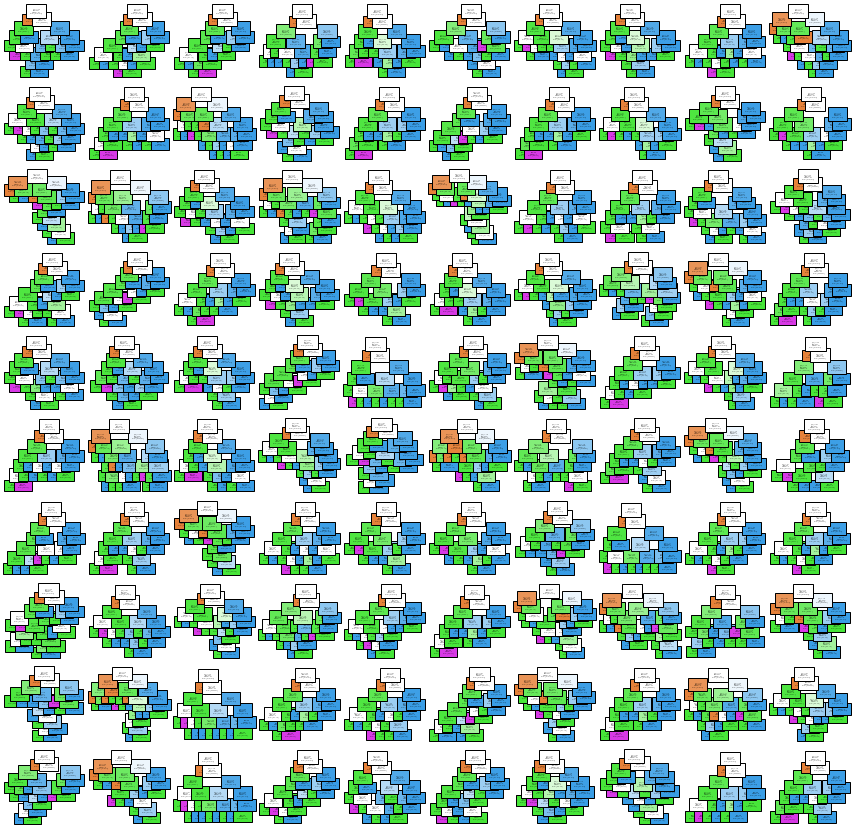

In [52]:
safeRFModel.model.min_samples_leaf = 1

safeRFModel.fit(X, y)

print(f"Training set accuracy in this naive case is {safeRFModel.score(X,y)}")
print("you cna see there are now unsafe trees again")

fig, ax = plt.subplots(10, 10, figsize=(15, 15))
for row in range(10):
    for column in range(10):
        whichTree = 10 * row + column
        treeRowCol = safeRFModel.estimators_[whichTree]
        _ = plot_tree(treeRowCol, filled=True, ax=ax[row][column], fontsize=1)

### This has let the user reset the params so that the model is now disclosive once again.

## Question: what do we do here:
1. Find a way of obfuscating the params so that they cannot be changed from outside the wrapper class
  - hard, not very python esque
  - also what if the use wants to increase min_samples_leaf which would make the model less disclosive than the default values?
  - **we've discarded this approach as impractical**
2. Put code into various method within the main class that checks the param values and says if they have been changed.
 - constraints are  stored the "safe" param values in a read-only file  
   and reads that into a dict in the init() and preliminary_check() and request_release() methods. 
    - The dict key is name of parameter name, value is a tuple of [operator, value]  
      where operator is one of ["min" |"equals" | "max"] and value is applied to operator
    - the dict is read afresh in __init__() and in make_report() to prevent users amending values 
 - this would have the benefit of allowing users to increase the min_samples_leaf but report when it was taken below our threshold
 
 - issue is how to deal with situations where the safety is built from a non-linear interaction between param values
   - that is a problem to deal with in the second stage of the project once we have proved the concept
 

In [87]:
import importlib, SafeModel

importlib.reload(SafeModel)


from SafeModel import SafeModel, SafeRandomForest

In [88]:
# create and fit using recommended params
print("***Test 1: researcher doesn't change recommended params")
safeRFModel2 = SafeRandomForest()
safeRFModel2.fit(X, y)
safeRFModel2.save_model(name="safe2.pkl")
safeRFModel2.preliminary_check()
safeRFModel2.request_release(filename="safe2.pkl")


# change model params to recommended values
print("\n***Test 2: researcher changes params safely")
safeRFModel3 = SafeRandomForest()
safeRFModel3.model.min_samples_leaf = 6
safeRFModel3.fit(X, y)
safeRFModel3.save_model(name="safe3.pkl")
safeRFModel3.preliminary_check()
safeRFModel3.request_release(filename="safe3.pkl")


# change one model params in an unsafe way
print("\n***Test 3: researcher changes string params unsafely")
safeRFModel4 = SafeRandomForest()
safeRFModel4.model.bootstrap = False
safeRFModel4.fit(X, y)
safeRFModel4.save_model(name="unsafe1.pkl")
safeRFModel4.preliminary_check()
safeRFModel4.request_release(filename="unsafe1.pkl")


# change another model params in an  unsafe way
print("\n***Test 4: researcher changes numeric params unsafely")
safeRFModel5 = SafeRandomForest()
safeRFModel5.model.bootstrap = True
safeRFModel5.model.min_samples_leaf = 2
safeRFModel5.save_model(name="unsafe2.pkl")
safeRFModel5.preliminary_check()
safeRFModel5.request_release(filename="unsafe2.pkl")

# change another model params in an  unsafe way
print("\n***Test 5: researcher changes string and numeric params unsafely")
safeRFModel6 = SafeRandomForest()
safeRFModel6.model.bootstrap = False
safeRFModel6.model.min_samples_leaf = 2
safeRFModel6.save_model(name="unsafe3.pkl")
safeRFModel6.preliminary_check()
safeRFModel6.request_release(filename="unsafe3.pkl")

***Test 1: researcher doesn't change recommended params
Model has not been changed to increase risk of disclosure.
 These are the params:
- parameter bootstrap unchanged at recommended value True
- parameter min_samples_leaf unchanged at recommended value 5



***Test 2: researcher changes params safely
Model has not been changed to increase risk of disclosure.
 These are the params:
- parameter bootstrap unchanged at recommended value True
- parameter min_samples_leaf increased from recommended min value of 5 to 6. This is not problematic.




***Test 3: researcher changes string params unsafely

- parameter bootstrap changed from recommended fixed value of True to False. THIS IS POTENTIALLY PROBLEMATIC.

- parameter min_samples_leaf unchanged at recommended value 5



***Test 4: researcher changes numeric params unsafely

- parameter bootstrap unchanged at recommended value True
- parameter min_samples_leaf decreased from recommended min value of 5 to 2. THIS IS POTENTIALLY PROBLEMAT

In [89]:
!echo "contents of checkfile are"; cat *_check*ile.txt

contents of checkfile are
j4-smith created model of type RandomForestClassifier saved as safe2.pkl
Model has not been changed to increase risk of disclosure:
- parameter bootstrap unchanged at recommended value True
- parameter min_samples_leaf unchanged at recommended value 5

RECOMMENDATION: Run file safe2.pkl through next step of checking procedure

j4-smith created model of type RandomForestClassifier saved as safe3.pkl
Model has not been changed to increase risk of disclosure:
- parameter bootstrap unchanged at recommended value True
- parameter min_samples_leaf increased from recommended min value of 5 to 6. This is not problematic.


RECOMMENDATION: Run file safe3.pkl through next step of checking procedure

j4-smith created model of type RandomForestClassifier saved as unsafe1.pkl
- parameter bootstrap changed from recommended fixed value of True to False. THIS IS POTENTIALLY PROBLEMATIC.

- parameter min_samples_leaf unchanged at recommended value 5

RECOMMENDATION: Do not all